In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
#import helpers.images.offline_image_helper as offline_image_helper
#from helpers.plotting import basic_plotting
from tensorflow.keras.applications import vgg19


## Assign graphic card memory dynamicly

In [3]:
physical_device = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

## provide a location and output a numpy image

In [4]:
from PIL import Image

def load_image(location,target_size=None):
    """
    provide a location and output a numpy image.
    """
    img = Image.open(location)
    if target_size == None:     
        return np.array(img)
    else:
        img = np.array(img.resize(target_size))
        return img


## input a list of images and it plots them with num_rows rows

In [5]:
import io
import base64
from IPython.display import HTML

def plot_image_grid(images,num_rows=1):
    """
    input a list of images and it plots them with num_rows rows."""
    n= len(images)
    num_cols = np.ceil(n/num_rows)
    fig,axes = plt.subplots(ncols=int(num_cols),nrows=int(num_rows))
    axes = axes.flatten()
    fig.set_size_inches((15,15))
    for i,image in enumerate(images):
        axes[i].imshow(image)

def place_video(location_of_video):
    """
    location_of_video: location of mp4 video"""
    video = io.open(location_of_video, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''.format(encoded.decode('ascii')))

In [81]:
wave_loc = 'shanshui.jpg'
golden_gate_loc = 'test3.jpg'

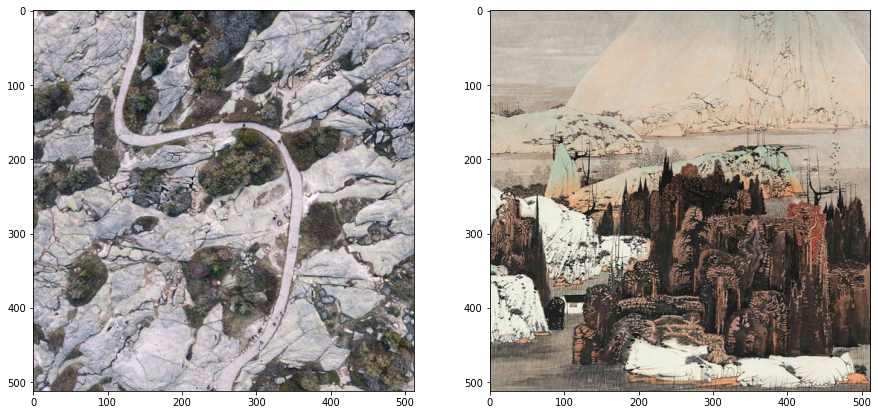

In [82]:
golden_gate_img = load_image(golden_gate_loc,target_size=(512,512))
wave_img = load_image(wave_loc,target_size=(512,512))
plot_image_grid([golden_gate_img,wave_img])

In [83]:
#wave_img = np.float32(wave_img)[:,:,:3]

In [84]:
base_model=vgg19.VGG19(include_top=False,weights="imagenet",)

In [85]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [86]:
CONTENT_LAYERS = ["block5_conv2"]
OUTPUT_LAYERS = ["block4_conv1","block4_conv2","block4_conv3","block4_conv4"]

In [87]:
def make_model(include_full= False,input_shape =None):
    if include_full:
        base_model=vgg19.VGG19(include_top=True,weights="imagenet")
        return base_model      
    if input_shape!=None:
        base_model=vgg19.VGG19(include_top=False,input_shape=input_shape,weights="imagenet")
    else:
        base_model=vgg19.VGG19(include_top=False,weights="imagenet")
    base_model.trainable= False
    content_layers =CONTENT_LAYERS
    style_layers = OUTPUT_LAYERS
    output_layers = [base_model.get_layer(layer).output for layer in (content_layers+style_layers)]
    return tf.keras.models.Model(base_model.input,output_layers)

# Now we will make the base model for the style transfer

## But first some experimentation to "feel" what we are doing

In [88]:
style_img = wave_img
content_img = golden_gate_img

In [89]:
content_img_noised = content_img + np.random.randn(*content_img.shape)*10
content_img_noised = content_img_noised.astype("float32")

In [90]:
processed_wave = vgg19.preprocess_input(np.expand_dims(wave_img,axis=0))
processed_golden_gate = vgg19.preprocess_input(np.expand_dims(golden_gate_img,axis=0))


# VGG takes the image and applies a bias to it as well as changes RGB channels to BGR channels.

In [91]:
VGG_BIASES = vgg19.preprocess_input((np.zeros((3))).astype("float32"))

In [92]:
def deprocess(processed_img):
    unprocessed_img = processed_img-VGG_BIASES
    unprocessed_img = tf.unstack(unprocessed_img,axis=-1)
    unprocessed_img = tf.stack([unprocessed_img[2],unprocessed_img[1],unprocessed_img[0]],axis=-1)
    return unprocessed_img

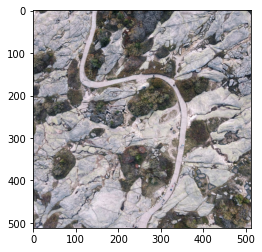

In [93]:
plt.imshow(np.round(deprocess(processed_golden_gate)[0])/255)

# Now let's get the outputs from the base model

In [94]:
base_model= make_model()

In [95]:
golden_gate_outputs = base_model(processed_golden_gate)
wave_outputs = base_model(processed_wave)

In [96]:
golden_gate_content = golden_gate_outputs[0]
wave_content = wave_outputs[0]

## We see that between the noised turtle image and the turtle image we have very low loss. This is becauseat that layer we have already supposedly filtered away most of the noise and are left with only the measure of turtleness... or more specifically the turtleness of that image. 

In [97]:
def get_content_loss(new_image_content,base_image_content):
    return np.mean(np.square(new_image_content-base_image_content))

# Now to understand the style loss.

## The neural network can be understood as pulling out the basis of the content and style. 

In [98]:
def get_gram_matrix(output):
    first_style_layer = output
    A = tf.reshape(first_style_layer,(-1,first_style_layer.shape[-1])) 
    n = A.shape[0]
    gram_matrix = tf.matmul(A,A,transpose_a=True)
    n=gram_matrix.shape[0]
    return gram_matrix/tf.cast(n,"float32"),n
    

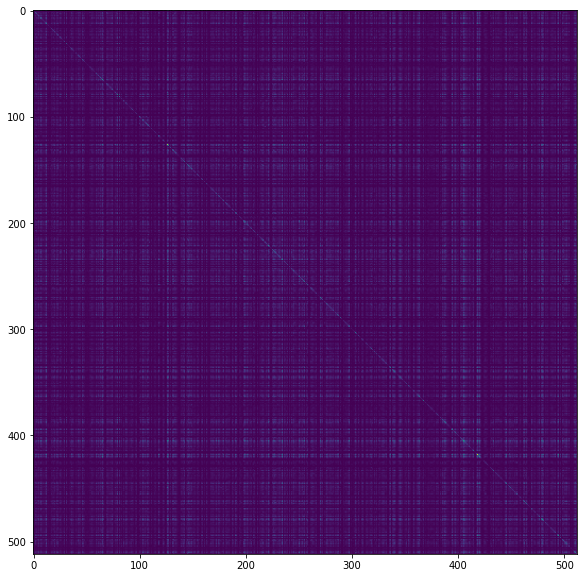

In [99]:
gram_matrix,N = get_gram_matrix(wave_outputs[2])
plt.figure(figsize=(10,10))
plt.imshow(gram_matrix.numpy());

In [100]:
def get_style_loss(new_image_style,base_style):
    new_style_gram,gram_num_height = get_gram_matrix(new_image_style)
    base_style_gram,gram_num_height2 = get_gram_matrix(base_style)
    assert gram_num_height == gram_num_height2
    gram_num_features = new_style_gram.shape[0]
    loss=tf.reduce_sum(tf.square(base_style_gram-new_style_gram)/(4*(gram_num_height**2)*(gram_num_features**2)))
    return loss

In [101]:
def get_total_loss(new_image_output,base_content_image_output,base_style_image_output,alpha=.999):
    new_image_styles = new_image_output[len(CONTENT_LAYERS):]
    base_image_styles = base_style_image_output[len(CONTENT_LAYERS):]
    style_loss=0
    N = len(new_image_styles)
    for i in range(N):
        style_loss+=get_style_loss(new_image_styles[i],base_image_styles[i])
    
    new_image_contents = new_image_output[:len(CONTENT_LAYERS)]
    base_image_contents = base_content_image_output[:len(CONTENT_LAYERS)]
    content_loss = 0
    N = len(new_image_contents)
    for i in range(N):
        content_loss+=get_content_loss(new_image_contents[i],base_image_contents[i])/N
    
    return (1-alpha)*style_loss+alpha*content_loss


In [102]:
get_total_loss(wave_outputs,golden_gate_outputs,wave_outputs)

<tf.Tensor: shape=(), dtype=float32, numpy=3177.5728>

# Now we will do training.

## Style Transfer is special. In most machine learning applications you want to train the model. Applying gradient descent on the weights of edges on a neural network. However, in style transfer we are applying optimization on our input... Updating the input 

In [103]:
base_style_outputs = base_model(processed_wave)

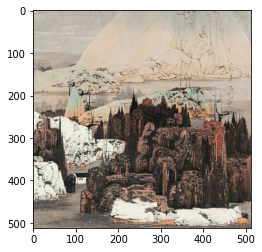

In [104]:
plt.imshow(deprocess(processed_wave)[0]/255)

In [105]:
base_content_output = base_model(processed_golden_gate)

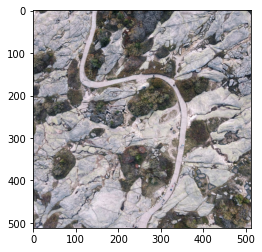

In [106]:
plt.imshow(deprocess(processed_golden_gate)[0]/255)

In [107]:
processed_content_var = tf.Variable(processed_golden_gate+tf.random.normal(processed_golden_gate.shape))

In [108]:
optimizer = tf.optimizers.Adam(5,beta_1=.99,epsilon=1e-3)

In [109]:
from IPython.display import display,clear_output

In [110]:
images = []
losses =[]

In [111]:
i=0
best_loss =200000
min_vals = VGG_BIASES
max_vals = 255+VGG_BIASES
for i in range(200):   
    with tf.GradientTape() as tape:
        tape.watch(processed_content_var)
        content_var_outputs = base_model(processed_content_var)
        loss = get_total_loss(content_var_outputs,base_content_output,base_style_outputs,alpha=.97)
        grad = tape.gradient(loss,processed_content_var)
        losses.append(loss)
        optimizer.apply_gradients(zip([grad],[processed_content_var]))
        clipped = tf.clip_by_value(processed_content_var, min_vals, max_vals)
        processed_content_var.assign(clipped)
        if i%5 ==0:
            images.append(deprocess(processed_content_var))
        if loss<best_loss:
            best_image = processed_content_var
            best_loss=loss
        display(loss)
        clear_output(wait=True)

<tf.Tensor: shape=(), dtype=float32, numpy=2785.2954>

In [112]:
deprocessed_best_image = deprocess(best_image)

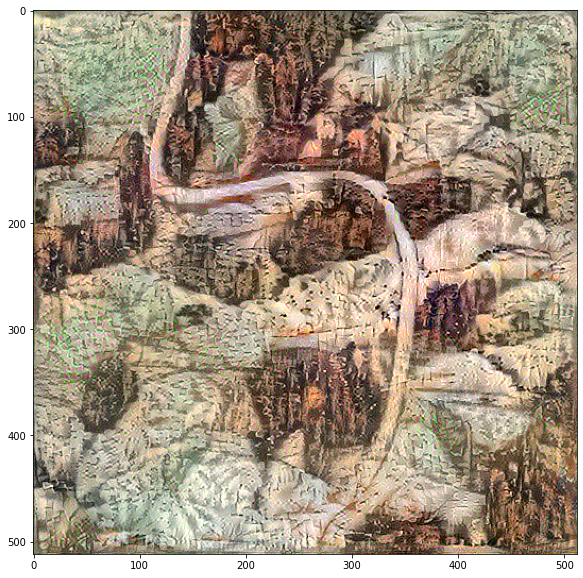

In [113]:
plt.figure(figsize=(10,10))
plt.imshow(deprocessed_best_image[0]/255)

# Make the animation.

In [114]:
from matplotlib.animation import FuncAnimation

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))
def update(i):
    im_normed = images[i].numpy().reshape((512,512,3))/255
    ax.imshow(im_normed)
    ax.set_title("Loss: {}".format(losses[i]), fontsize=20)
    ax.set_axis_off()
anim = FuncAnimation(fig, update, frames=np.arange(0, len(images)), interval=50)
anim.save('style_transfer.mp4', dpi=80, writer='ffmpeg')
plt.close()

In [116]:
import importlib

In [117]:

place_video('style_transfer.mp4')